In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from arch.bootstrap import MCS

### Logistic link (sigmoid)

We use the standard logistic function to map scores to Bernoulli click probabilities:
$
\sigma(u) = \frac{1}{1+e^{-u}}.
$

When arm $a$ is played under context $x_t$, the success probability is
$
p_{t,a} = \sigma(x_t^\top \theta_a).
$


In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Experiment configuration

- Number of arms: $K$  
- Context dimension: $d$  
- Horizon (rounds per run): $T$  
- Repeated runs for stability: $R$  

In code, we set typical values such as `K=5`, `d=5`, `T=2000`, `R=100`.  
We seed RNGs for reproducibility.


In [7]:
narms = 5 

d = 5              
steps = 2000
repeats = 100
np.random.seed(42) 

true_thetas = [np.random.normal(0, 1, d) for _ in range(narms)]

### Policy interface and updates

We follow a simple interface with two methods:
- `select_arm(x)`: choose an arm given context $x_t$
- `update(x, a, r)`: update internal statistics with observed $(x_t, a_t, r_t)$

Examples:

**$\epsilon$-greedy (linear score).** Maintain per-arm linear estimates $\hat\theta_a$. With prob. $\epsilon$ explore uniformly; otherwise exploit via $\arg\max_a x_t^\top \hat\theta_a$.

**LinUCB.** Maintain $A_a = \lambda I + X_a^\top X_a$, $b_a = X_a^\top y_a$, $\hat\theta_a=A_a^{-1}b_a$, and select
$
a_t=\arg\max_a \big(x_t^\top \hat\theta_a + \alpha \sqrt{x_t^\top A_a^{-1} x_t}\big).
$

**Linear Thompson Sampling.** Sample $\tilde\theta_a \sim \mathcal{N}(\hat\theta_a, A_a^{-1})$, then play $\arg\max_a x_t^\top \tilde\theta_a$.


In [12]:
class CAB_EpsGreedy:
    def __init__(self, narms, d, epsilon, lam=1e-4):
        self.narms = narms
        self.d = d
        self.epsilon = epsilon
        self.lam = lam
        self.theta = [np.zeros(d) for _ in range(narms)]

        inv_lam = 1.0 / lam
        self.P = [inv_lam * np.eye(d) for _ in range(narms)]



    def select_arm(self, context):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.narms)
        preds = [np.dot(context, self.theta[a]) for a in range(self.narms)]
        return np.argmax(preds)

    def update(self, context, arm, reward):
        x = context.reshape(-1)                
        P = self.P[arm]                         
        theta = self.theta[arm]                 

        pred = float(x @ theta)
        err  = reward - pred                    

        Px = P @ x                              
        s  = 1.0 + float(x @ Px)                
        K  = Px / s                             

        theta_new = theta + K * err
        P_new = P - np.outer(K, x) @ P

        self.theta[arm] = theta_new
        self.P[arm]     = P_new



class CAB_LinUCB:
    def __init__(self, narms, d, alpha):
        self.narms = narms
        self.d = d
        self.alpha = alpha

        self.A = [np.identity(d) for _ in range(narms)]
        self.b = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        p = np.zeros(self.narms)
        for a in range(self.narms):
            A_inv = np.linalg.inv(self.A[a])
            theta_a = A_inv @ self.b[a]
            p[a] = context @ theta_a + self.alpha * np.sqrt(context @ A_inv @ context)
        return np.argmax(p)

    def update(self, context, arm, reward):
        x = context.reshape(-1, 1)
        self.A[arm] += x @ x.T
        self.b[arm] += reward * context



class CAB_ThompsonSampling:
    def __init__(self, narms, d):
        self.narms = narms
        self.d = d
        self.X = [np.zeros((0, d)) for _ in range(narms)]
        self.y = [np.array([]) for _ in range(narms)]
        self.theta_samples = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        preds = []
        for a in range(self.narms):
            if self.X[a].shape[0] < self.d:
                preds.append(np.random.rand())
                continue
            XTX = self.X[a].T @ self.X[a] + 1e-4 * np.eye(self.d)
            XTy = self.X[a].T @ self.y[a]
            theta_mean = np.linalg.solve(XTX, XTy)
            cov = np.linalg.inv(XTX)
            theta_sample = np.random.multivariate_normal(theta_mean, cov)
            preds.append(np.dot(context, theta_sample))
        return np.argmax(preds)

    def update(self, context, arm, reward):
        self.X[arm] = np.vstack([self.X[arm], context])
        self.y[arm] = np.append(self.y[arm], reward)



### Simulation loop

For each round $t=1,\dots,T$:
1. Sample context $x_t \sim \mathcal{N}(0, I_d)$
2. Policy chooses arm $a_t = \text{select\_arm}(x_t)$
3. Generate reward $r_t \sim \mathrm{Bernoulli}(\sigma(x_t^\top \theta_{a_t}))$
4. Update policy with $(x_t, a_t, r_t)$


We record cumulative reward and (optionally) pseudo-regret:
$
\mathcal{R}_T = \sum_{t=1}^T \left[\sigma(x_t^\top \theta_{a_t^\star}) - \sigma(x_t^\top \theta_{a_t})\right], \quad
a_t^\star = \arg\max_a \sigma(x_t^\top \theta_a).
$


In [3]:
def run_experiment_cab(policy_class, true_thetas, steps, d, **kwargs):
    narms = len(true_thetas)
    bandit = policy_class(narms, d, **kwargs)
    rewards = np.zeros(steps)

    for t in range(steps):
        context = np.random.normal(0, 1, d)
        arm = bandit.select_arm(context)
        click_prob = sigmoid(np.dot(context, true_thetas[arm]))
        reward = np.random.binomial(1, click_prob)
        bandit.update(context, arm, reward)
        rewards[t] = reward

    return rewards


In [8]:
policy_configs = {
    "Eps=0.0": (CAB_EpsGreedy, {"epsilon": 0.0}),
    "Eps=0.1": (CAB_EpsGreedy, {"epsilon": 0.1}),
    "Eps=0.3": (CAB_EpsGreedy, {"epsilon": 0.3}),
    "Eps=0.5": (CAB_EpsGreedy, {"epsilon": 0.5}),
    "LinUCB": (CAB_LinUCB, {"alpha": 0.5}),
    "TS": (CAB_ThompsonSampling, {}),
}


cumulative_rewards = {}

for name, (policy_class, params) in policy_configs.items():
    reward_list = []
    for _ in range(repeats):
        rewards = run_experiment_cab(policy_class, true_thetas, steps, d, **params)
        total_reward = rewards.sum()
        reward_list.append(total_reward)
    cumulative_rewards[name] = reward_list


### Model Confidence Set (MCS)

Let $\ell_m$ be the loss for model/policy $m$ on each repeated run (e.g., negative cumulative reward).
Define pairwise loss differentials $d_{m,m'} = \ell_m - \ell_{m'}$. The MCS algorithm bootstraps
these differentials to test the null hypothesis “all models are equally good” and iteratively
removes significantly inferior models, yielding the $(1-\alpha)$ *Superior Set of Models*.


In [9]:
'''MCS'''
policy_names = list(cumulative_rewards.keys())
reward_matrix = []

for i in range(repeats):
    row = []
    for name in policy_names:
        row.append(cumulative_rewards[name][i])
    reward_matrix.append(row)

reward_matrix = np.array(reward_matrix)
loss_matrix = -reward_matrix


In [10]:
mcs = MCS(loss_matrix, size=0.05, reps=1000, block_size=1)
mcs.compute()

included_indices = mcs.included
included_policies = [policy_names[i] for i in included_indices]

print("MCS 95% policy set: ")
print(included_policies)


MCS 95% policy set: 
['LinUCB']


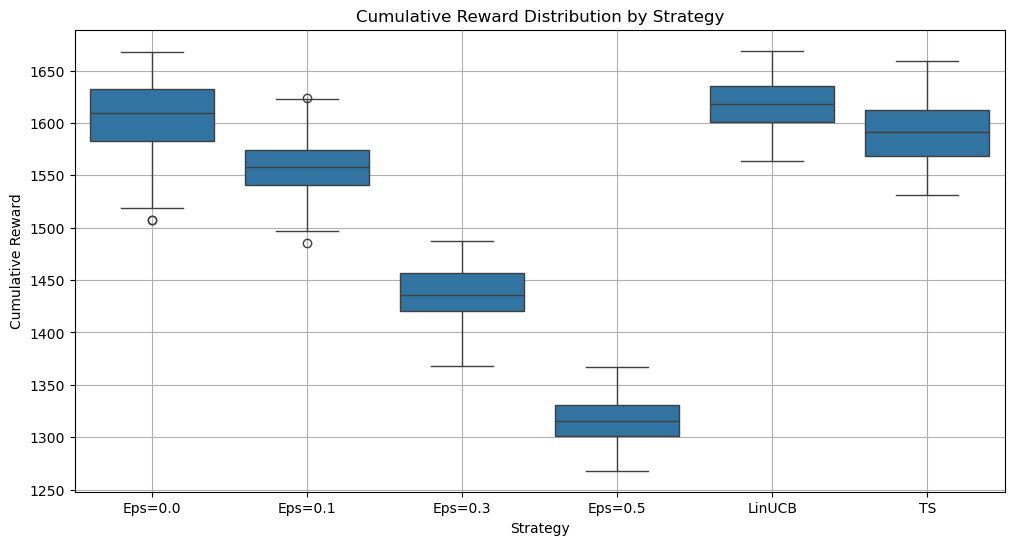

In [11]:
df = pd.DataFrame(cumulative_rewards)
df_melted = df.melt(var_name="Strategy", value_name="Cumulative Reward")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Strategy", y="Cumulative Reward")
plt.title("Cumulative Reward Distribution by Strategy")
plt.grid(True)
plt.show()



array([[-1580., -1578., -1459., -1327., -1612., -1616.],
       [-1560., -1586., -1385., -1294., -1579., -1613.],
       [-1559., -1544., -1426., -1328., -1584., -1595.],
       [-1580., -1593., -1475., -1330., -1593., -1574.],
       [-1587., -1543., -1448., -1285., -1611., -1643.],
       [-1583., -1542., -1411., -1321., -1608., -1619.],
       [-1630., -1604., -1423., -1333., -1586., -1606.],
       [-1620., -1573., -1464., -1322., -1612., -1588.],
       [-1558., -1560., -1414., -1307., -1584., -1561.],
       [-1629., -1571., -1426., -1283., -1617., -1600.],
       [-1553., -1586., -1475., -1311., -1632., -1531.],
       [-1590., -1591., -1412., -1293., -1661., -1579.],
       [-1624., -1527., -1446., -1306., -1663., -1580.],
       [-1597., -1576., -1434., -1321., -1613., -1602.],
       [-1596., -1510., -1442., -1299., -1630., -1577.],
       [-1612., -1565., -1477., -1354., -1596., -1620.],
       [-1615., -1604., -1399., -1339., -1620., -1584.],
       [-1609., -1555., -1418.,